In [39]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os

# 回测框架
import backtrader as bt
import backtrader.feeds as btfeed
import backtrader.indicators as btind

# 基础函数
import utilsJ

### 策略

In [104]:
class IFStrategy_1(bt.Strategy):
    params = (
        ('printlog', False),
        ('b_per', 20),
        ('b_dev', 2),
        ('pos_max', 10),
    )
    
    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.data.close

        # To keep track of pending orders and buy & sell price
        self.order = None
        self.buyprice = None
        self.sellprice = None

        # Add Bollinger Bands indicator
        self.lines.top = btind.BollingerBands(self.data, 
                                              period=self.p.b_per, 
                                              devfactor=self.p.b_dev).top
        self.lines.bot = btind.BollingerBands(self.data, 
                                              period=self.p.b_per, 
                                              devfactor=self.p.b_dev).bot

        # Create buy & sell signal
        self.buy_s = bt.Or(bt.And(self.dataclose(0) > self.lines.top(0), 
                                  self.dataclose(-1) < self.lines.top(-1)),
                           bt.And(self.dataclose(0) > self.lines.bot(0), 
                                  self.dataclose(-1) < self.lines.bot(-1)))
        
        self.sell_s = bt.Or(bt.And(self.dataclose(0) < self.lines.top(0), 
                                  self.dataclose(-1) > self.lines.top(-1)),
                           bt.And(self.dataclose(0) < self.lines.bot(0), 
                                  self.dataclose(-1) > self.lines.bot(-1)))


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Lot:%i, Position:%i, Cash: %i, Value: %i' %
                         (order.executed.price,
                          order.executed.size,
                          self.getposition(self.data).size,
                          self.broker.get_cash(),
                          self.broker.get_value()))
                
                self.buyprice = order.executed.price

            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Lot:%i, Position:%i, Cash: %i, Value: %i' %
                         (order.executed.price,
                          -order.executed.size,
                          self.getposition(self.data).size,
                          self.broker.get_cash(),
                          self.broker.get_value()))

                self.sellprice = order.executed.price
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))


    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        # Check if position size exceeds the limit
        if abs(self.getposition(self.data).size) > self.params.pos_max:
            # Close short position
            if self.getposition(self.data).size < 0:
                self.log('BUY CREATE (Close Short), Price: %.2f' % self.dataclose[0])
                self.order = self.buy(size=-self.getposition(self.data).size)

            # Close long position
            if self.getposition(self.data).size > 0:
                self.log('SELL CREATE (Close Long), Price: %.2f' % self.dataclose[0])
                self.order = self.sell(size=self.getposition(self.data).size)

        lot_ava = (self.broker.get_cash() / 2) //  (self.data.close[0])

        if self.buy_s[0]:
            if lot_ava > 0:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy(size = lot_ava)
            else:
                self.log('BUY FAILED (Insufficient Funds)')

        else:
            if  self.sell_s[0]:
                if lot_ava > 0:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell(size = lot_ava)
                elif lot_ava < 0:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell(size = self.getposition(self.data).size)
        
    def stop(self):
        self.log('(Period %2d, DevFactor %.2f). Ending Position %i. Ending Value %.2f' %
                 (self.params.b_per, self.params.b_dev, self.getposition(self.data).size, self.broker.getvalue()), doprint = False)

### 回测

In [113]:
if __name__ ==  '__main__':
    max_np = 0.0
    max_idx = (0, 0.0)
    s_date = datetime.datetime.now() - datetime.timedelta(days=365)
    e_date = datetime.datetime.now()
    df = utilsJ.index_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6',
                               'IFL.CFX', s_date, e_date)

    for i in range(3, 31, 1):
        for j in np.arange(0.2, 2.1, 0.1):
            # Create a cerebro entity
            cerebro = bt.Cerebro()

            # Add a strategy
            strats = cerebro.addstrategy(IFStrategy_1, printlog = False, b_per = i, b_dev = float(j)) 

            # Create a Data Feed
            data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

            # Add the Data Feed to Cerebo
            cerebro.adddata(data)

            # Set our desired cash start
            cerebro.broker = bt.brokers.BackBroker(coc=True)
            
            cerebro.broker.setcash(100000.00)
            # Set leverage
            cerebro.broker.setcommission(mult = 10)

            # Add a FixedSize sizer according to the stake
            #cerebro.addsizer(HalfCashSizer)

            # Print out the starting conditions
            start_value = cerebro.broker.getvalue()
            #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

            # Run over everything
            cerebro.run()

            # Print out the final result
            final_value = cerebro.broker.getvalue()
            netp = (final_value / start_value -1)*100
            if netp > max_np:
                max_np = netp
                max_idx = (i, j)
print(max_np, max_idx)

118.52599999999956 (21, 2.000000000000001)


<IPython.core.display.Javascript object>


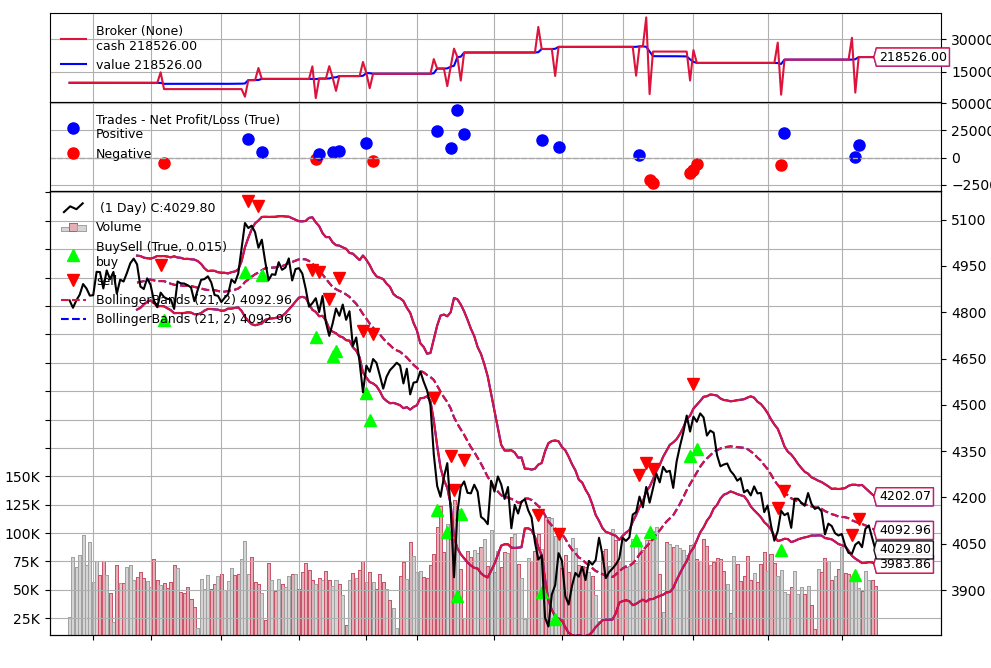

[[<Figure size 640x480 with 4 Axes>]]

In [115]:
cerebro.plot()